Original Data Shape: (5110, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.fram

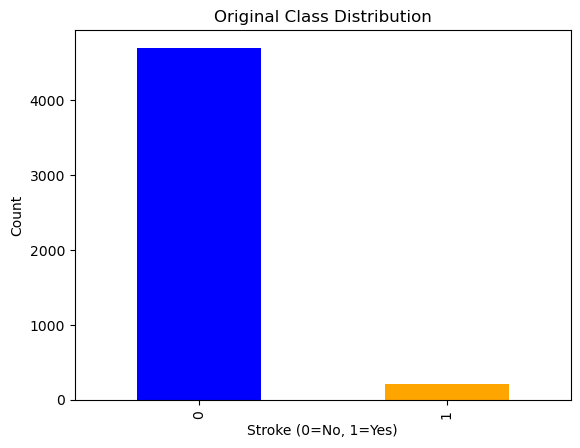

X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature na

After SMOTE: X_resampled shape: (9400, 16) | y_resampled shape: (9400,)


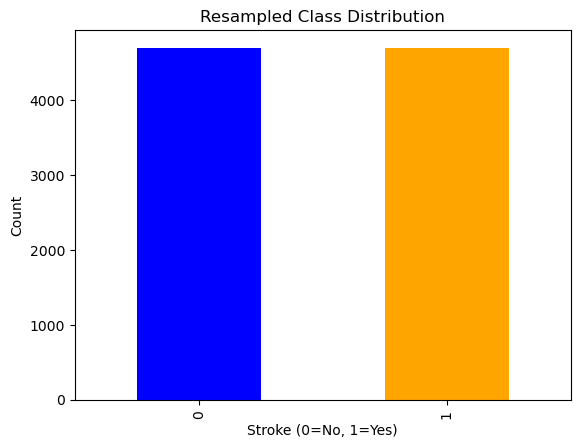


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       940
           1       0.94      0.97      0.96       940

    accuracy                           0.96      1880
   macro avg       0.96      0.96      0.96      1880
weighted avg       0.96      0.96      0.96      1880



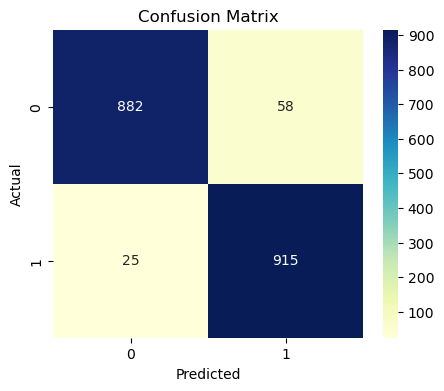

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors

# ----------------------------------------------------------------
# 1. A BASIC CUSTOM SMOTE IMPLEMENTATION (no 'imblearn' needed)
# ----------------------------------------------------------------
def simple_smote(X, y, minority_class=1, k_neighbors=5, random_state=42):
    """
    A basic SMOTE-like oversampling: create synthetic minority samples by
    interpolating between neighbors. For demonstration only.

    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target vector.
    minority_class : int or str
        Label of the minority class.
    k_neighbors : int
        Number of nearest neighbors to use.
    random_state : int
        Seed for reproducibility.

    Returns:
    --------
    (X_resampled, y_resampled) : (pd.DataFrame, pd.Series)
    """
    np.random.seed(random_state)

    # Split minority vs. majority
    X_min = X[y == minority_class].copy()
    y_min = y[y == minority_class].copy()

    X_maj = X[y != minority_class].copy()
    y_maj = y[y != minority_class].copy()

    n_min = len(X_min)
    n_maj = len(X_maj)

    # If minority is zero or not smaller, no oversampling needed
    if n_min == 0 or n_min >= n_maj:
        return X.copy(), y.copy()

    n_to_create = n_maj - n_min
    if n_to_create <= 0:
        return X.copy(), y.copy()

    # kNN on minority samples
    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_min)

    synthetic_samples = []
    for _ in range(n_to_create):
        idx = np.random.randint(0, n_min)
        x_orig = X_min.iloc[idx].values.reshape(1, -1)

        # Neighbors (indices)
        neighbors = neigh.kneighbors(x_orig, return_distance=False)[0]
        # Pick a random neighbor (excluding itself if possible)
        if len(neighbors) > 1:
            neighbor_idx = np.random.choice(neighbors[1:])
        else:
            neighbor_idx = neighbors[0]
        x_neighbor = X_min.iloc[neighbor_idx].values

        # Interpolate
        lam = np.random.rand()
        x_synthetic = x_orig + lam * (x_neighbor - x_orig)
        synthetic_samples.append(x_synthetic.flatten())

    # Build new minority samples
    X_syn = pd.DataFrame(synthetic_samples, columns=X_min.columns)
    y_syn = pd.Series([minority_class]*len(X_syn), index=X_syn.index)

    # Concatenate old majority + old minority + new synthetic
    X_resampled = pd.concat([X_maj, X_min, X_syn], axis=0).reset_index(drop=True)
    y_resampled = pd.concat([y_maj, y_min, y_syn], axis=0).reset_index(drop=True)

    return X_resampled, y_resampled

# ----------------------------------------------------------------
# 2. MAIN PIPELINE
# ----------------------------------------------------------------
# -----------------------
# 2.1 Load & Clean Data
# -----------------------
data_path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(data_path)
# print("Original Data Shape:", df.shape)

# # Quick look at the data
# print(df.head())
# print(df.info())
# print(df.describe())
# print("Missing values:\n", df.isnull().sum())

# Drop NaN and infinite
df.dropna(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# If 'id' column exists and isn't needed, drop it
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

print("\nCleaned Data Shape:", df.shape)

# Class distribution (original)
plt.figure()
df['stroke'].value_counts().plot(kind='bar', color=['blue','orange'])
plt.title("Original Class Distribution")
plt.xlabel("Stroke (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

# -----------------------
# 2.2 Prepare for SMOTE
# -----------------------
y = df['stroke']
X = df.drop(columns=['stroke'])
# One-hot encode categorical
X = pd.get_dummies(X, drop_first=True)

# -----------------------
# 2.3 Apply Custom SMOTE
# -----------------------
X_resampled, y_resampled = simple_smote(X, y, minority_class=1, k_neighbors=5, random_state=42)
print("After SMOTE: X_resampled shape:", X_resampled.shape, "| y_resampled shape:", y_resampled.shape)

# Visualize new distribution
plt.figure()
y_resampled.value_counts().plot(kind='bar', color=['blue','orange'])
plt.title("Resampled Class Distribution")
plt.xlabel("Stroke (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

# -----------------------
# 2.4 Train-Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    stratify=y_resampled,
    random_state=42
)

# -----------------------
# 2.5 Scale Numeric Features
# -----------------------
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# -----------------------
# 2.6 Train MLP
# -----------------------
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# -----------------------
# 2.7 Evaluate Model
# -----------------------
y_pred = mlp.predict(X_test_scaled)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





================= SAMPLE #1 (Index=4496) =================

Feature values (original):
        age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
4496  77.0           0.0            0.0              59.91  18.3          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
4496           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
4496                0.0                      1.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
4496                   0.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
4496                          1.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level      bmi  \
4496  0.992601     -0.529939      -0.416098          -1.078277 -1.65712   

      gender_Male  gender_Other  ever_married_Yes  wo

X does not have valid feature names, but MLPClassifier was fitted with feature names


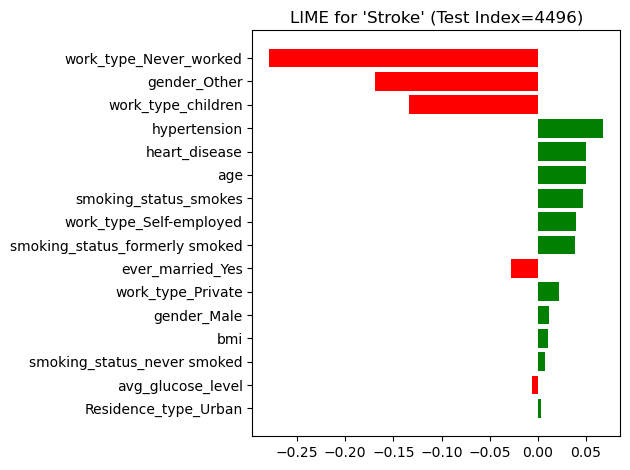

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=4496 (Class=1) computed.


================= SAMPLE #2 (Index=2386) =================

Feature values (original):
        age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
2386  17.0           0.0            0.0              88.57  31.1          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
2386           0.0               0.0                     1.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
2386                0.0                      0.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
2386                   0.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
2386                          1.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
2386 -1.732216     -0.529939      -0.416098          -0.567464  0.217226  

X does not have valid feature names, but MLPClassifier was fitted with feature names


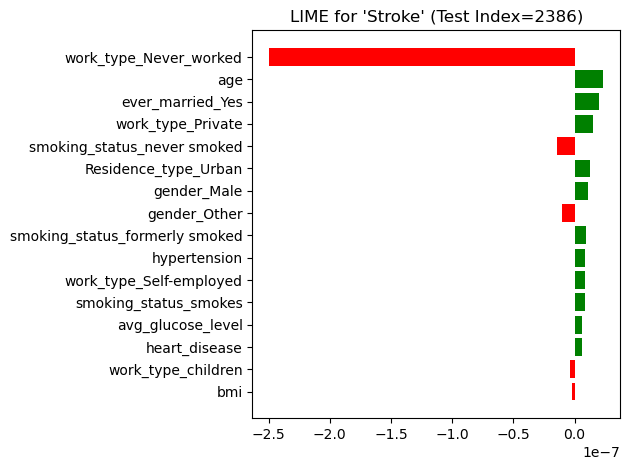

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=2386 (Class=1) computed.


================= SAMPLE #3 (Index=7883) =================

Feature values (original):
             age  hypertension  heart_disease  avg_glucose_level        bmi  \
7883  80.452215      0.547785            0.0           72.73331  27.724241   

      gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
7883     0.452215           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
7883           0.452215                 0.547785                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
7883              0.452215                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
7883                          1.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
7883  1.149378      1.051603      -0.416098          -

X does not have valid feature names, but MLPClassifier was fitted with feature names


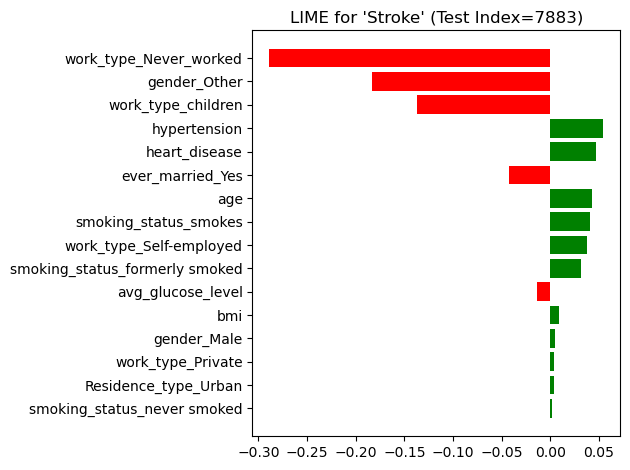

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=7883 (Class=1) computed.


================= SAMPLE #4 (Index=6476) =================

Feature values (original):
             age  hypertension  heart_disease  avg_glucose_level        bmi  \
6476  80.464239           0.0       0.535761          68.381974  23.603378   

      gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
6476          0.0           0.0          0.535761                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
6476                0.0                 0.535761                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
6476              0.464239                        0.535761   

      smoking_status_never smoked  smoking_status_smokes  
6476                          0.0               0.464239  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
6476  1.149925     -0.529939       1.460813          -

X does not have valid feature names, but MLPClassifier was fitted with feature names


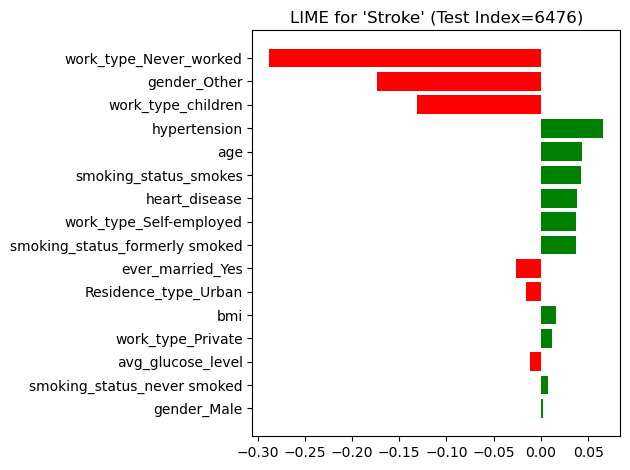

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=6476 (Class=1) computed.


================= SAMPLE #5 (Index=3818) =================

Feature values (original):
        age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
3818  12.0           0.0            0.0             111.08  23.2          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
3818           0.0               0.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
3818                0.0                      0.0                 1.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
3818                   0.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
3818                          1.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
3818 -1.959284     -0.529939      -0.416098          -0.166264 -0.939597  

X does not have valid feature names, but MLPClassifier was fitted with feature names


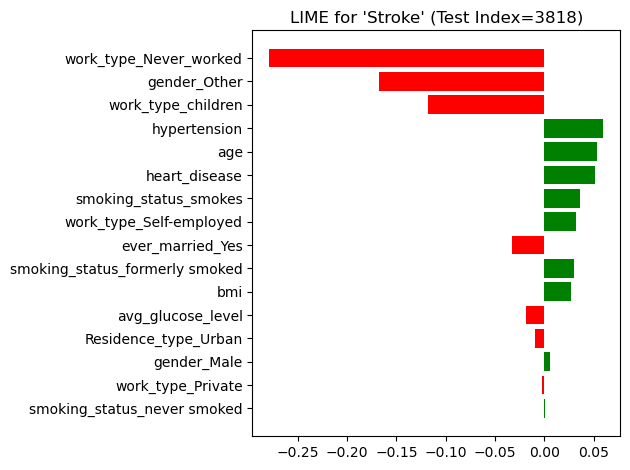

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=3818 (Class=1) computed.


================= SAMPLE #6 (Index=4355) =================

Feature values (original):
        age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
4355  59.0           0.0            0.0              83.62  34.2          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
4355           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
4355                1.0                      0.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
4355                   1.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
4355                          0.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
4355  0.175156     -0.529939      -0.416098          -0.655689  0.671169  

X does not have valid feature names, but MLPClassifier was fitted with feature names


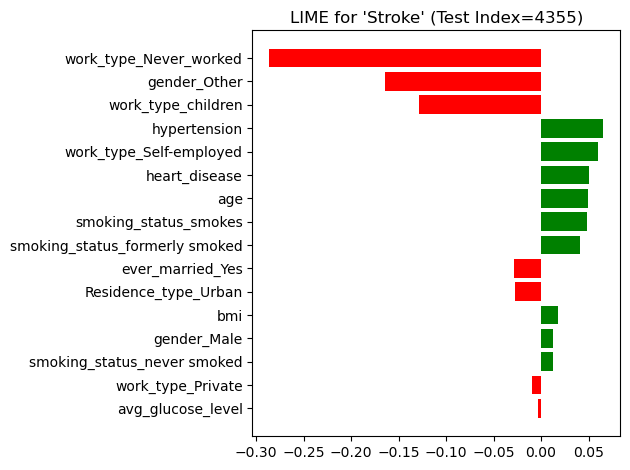

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=4355 (Class=1) computed.


================= SAMPLE #7 (Index=484) =================

Feature values (original):
       age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
484  71.0           1.0            0.0             194.62  31.6          0.0   

     gender_Other  ever_married_Yes  work_type_Never_worked  \
484           0.0               1.0                     0.0   

     work_type_Private  work_type_Self-employed  work_type_children  \
484                1.0                      0.0                 0.0   

     Residence_type_Urban  smoking_status_formerly smoked  \
484                   1.0                             0.0   

     smoking_status_never smoked  smoking_status_smokes  
484                          1.0                    0.0  

Feature values (scaled):
           age  hypertension  heart_disease  avg_glucose_level       bmi  \
484  0.720119       2.35722      -0.416098           1.322686  0.290442   

     gende

X does not have valid feature names, but MLPClassifier was fitted with feature names


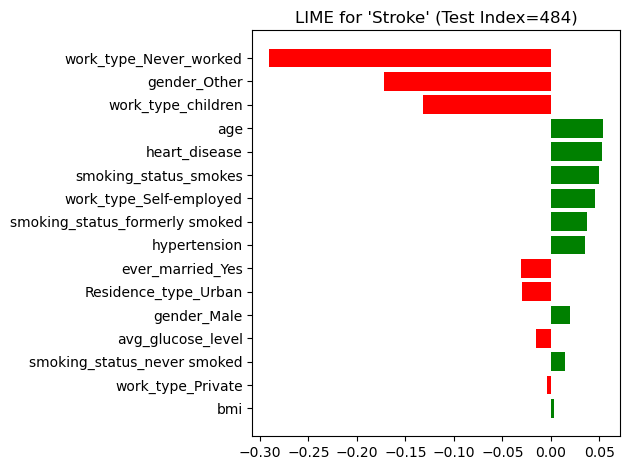

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=484 (Class=1) computed.


================= SAMPLE #8 (Index=8329) =================

Feature values (original):
             age  hypertension  heart_disease  avg_glucose_level        bmi  \
8329  54.765547           0.0            0.0         193.213295  38.894425   

      gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
8329     0.255182           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
8329           0.255182                 0.744818                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
8329                   0.0                        0.255182   

      smoking_status_never smoked  smoking_status_smokes  
8329                          0.0               0.744818  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
8329 -0.017146     -0.529939      -0.416098           1

X does not have valid feature names, but MLPClassifier was fitted with feature names


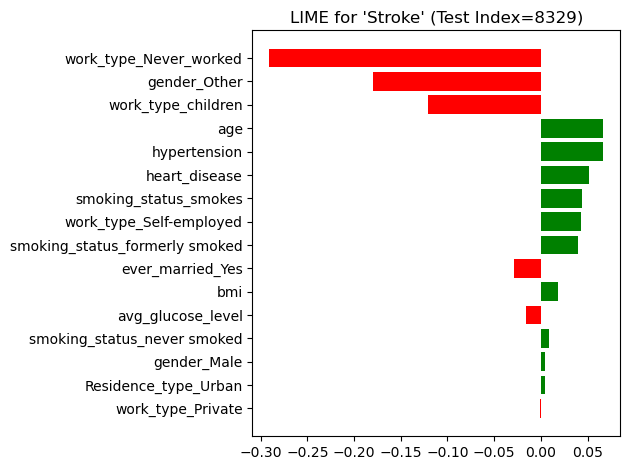

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=8329 (Class=1) computed.


================= SAMPLE #9 (Index=4894) =================

Feature values (original):
        age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
4894  77.0           1.0            0.0             199.84  28.0          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
4894           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
4894                0.0                      1.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
4894                   1.0                             1.0   

      smoking_status_never smoked  smoking_status_smokes  
4894                          0.0                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
4894  0.992601       2.35722      -0.416098           1.415723 -0.236717  

X does not have valid feature names, but MLPClassifier was fitted with feature names


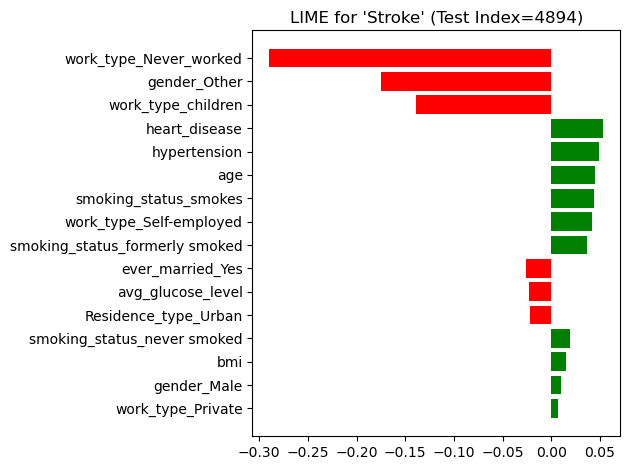

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=4894 (Class=1) computed.


================= SAMPLE #10 (Index=8152) =================

Feature values (original):
             age  hypertension  heart_disease  avg_glucose_level        bmi  \
8152  50.240705      0.310176            0.0          61.418689  30.024071   

      gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
8152          0.0           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
8152                1.0                      0.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
8152                   1.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
8152                     0.689824                    0.0  

Feature values (scaled):
            age  hypertension  heart_disease  avg_glucose_level       bmi  \
8152 -0.222635      0.365589      -0.416098          

X does not have valid feature names, but MLPClassifier was fitted with feature names


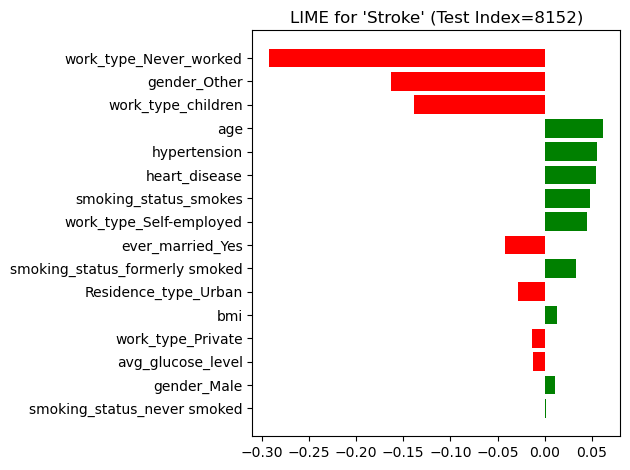

  0%|          | 0/1 [00:00<?, ?it/s]

Local SHAP values for index=8152 (Class=1) computed.



  0%|          | 0/50 [00:00<?, ?it/s]


=== SHAP Global Summary (Class=1 => 'Stroke') ===


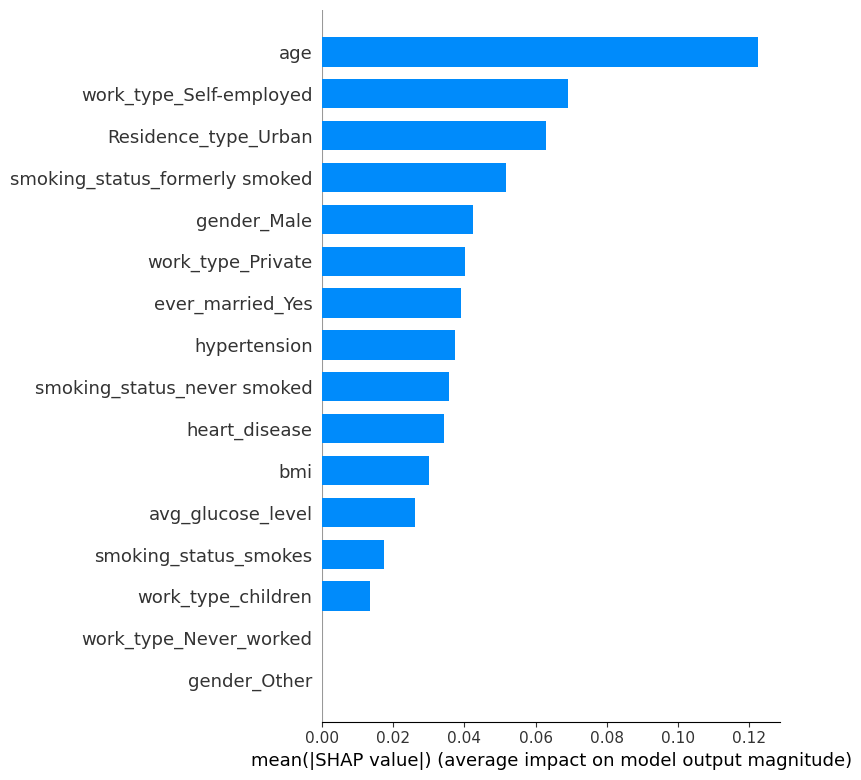


Done explaining random samples!


In [13]:
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

def explain_random_samples(X_train_scaled, X_test, X_test_scaled, y_test, mlp, num_samples=10):
    """
    Explain random 'num_samples' instances from X_test using both LIME and SHAP.
    
    Parameters
    ----------
    X_train_scaled : pd.DataFrame
        The scaled training set (used for LIME/SHAP background).
    X_test : pd.DataFrame
        The original (unscaled) test set.
    X_test_scaled : pd.DataFrame
        The scaled test set (matching columns & indices of X_test).
    y_test : pd.Series
        True labels for the test set.
    mlp : trained MLPClassifier (fitted on X_train_scaled, y_train)
    num_samples : int
        How many random test samples to explain.
    """

    # --------------------------------------
    # A. Setup: LIME & SHAP Explainers
    # --------------------------------------

    # 1) LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data = X_train_scaled.values,
        feature_names = X_train_scaled.columns.tolist(),
        class_names   = ["No Stroke", "Stroke"],
        mode          = 'classification',
        discretize_continuous=False
    )

    # 2) SHAP Explainer (KernelExplainer, model-agnostic)
    shap.initjs()  # for better notebook rendering
    background = X_train_scaled.sample(50, random_state=42)  # smaller background sample for speed
    shap_explainer = shap.KernelExplainer(mlp.predict_proba, background)

    # --------------------------------------
    # B. Pick 10 random test samples
    # --------------------------------------
    # Ensure we don't exceed the size of X_test
    n_test = len(X_test)
    num_samples = min(num_samples, n_test)

    # Choose random indices from X_test
    np.random.seed(42)  # for reproducibility
    random_indices = np.random.choice(X_test.index, size=num_samples, replace=False)

    # --------------------------------------
    # C. For each chosen sample, do a local explanation
    # --------------------------------------
    for i, idx in enumerate(random_indices, start=1):
        print(f"\n================= SAMPLE #{i} (Index={idx}) =================")

        # Original vs scaled features
        print("\nFeature values (original):\n", X_test.loc[[idx]])
        print("\nFeature values (scaled):\n", X_test_scaled.loc[[idx]])

        # Predicted probabilities
        probas = mlp.predict_proba(X_test_scaled.loc[[idx]])
        prediction = mlp.predict(X_test_scaled.loc[[idx]])
        true_label = y_test.loc[idx]

        print("\nPredicted probabilities (No Stroke, Stroke):", probas[0])
        print("Predicted class:", prediction[0])
        print("True class:", true_label)

        # LIME Explanation
        lime_exp = lime_explainer.explain_instance(
            data_row=X_test_scaled.loc[idx].values,
            predict_fn=mlp.predict_proba,
            num_features=len(X_test_scaled.columns),  # show all features
            labels=(0,1)
        )

        print("\n--- LIME Explanation (Class=1 => 'Stroke') ---")
        for feat, wgt in lime_exp.as_list(label=1):
            print(f"{feat:<40} Weight={wgt:.4f}")

        # Plot LIME bar chart for class=1
        lime_fig = lime_exp.as_pyplot_figure(label=1)
        plt.title(f"LIME for 'Stroke' (Test Index={idx})")
        plt.tight_layout()
        plt.show()

        # SHAP local explanation
        shap_values_local = shap_explainer.shap_values(X_test_scaled.loc[[idx]])
        print(f"Local SHAP values for index={idx} (Class=1) computed.\n")

        # (Optional) Force plot or other local SHAP plot in a notebook
        # Example (commented out):
        shap.force_plot(
            shap_explainer.expected_value[1],
            shap_values_local[1][0,:],
            X_test_scaled.loc[idx],
            feature_names=X_test_scaled.columns
        )

    # --------------------------------------
    # D. SHAP Global Explanation
    # --------------------------------------
    # We'll do a global summary on up to 50 test rows
    sample_size = min(50, len(X_test_scaled))
    shap_values_global = shap_explainer.shap_values(X_test_scaled.iloc[:sample_size])

    print("\n=== SHAP Global Summary (Class=1 => 'Stroke') ===")
    shap.summary_plot(
        shap_values_global[1],
        X_test_scaled.iloc[:sample_size],
        feature_names=X_test_scaled.columns,
        plot_type='bar'
    )
    plt.show()

    print("\nDone explaining random samples!")

explain_random_samples(
    X_train_scaled=X_train_scaled,
    X_test=X_test,
    X_test_scaled=X_test_scaled,
    y_test=y_test,
    mlp=mlp,
    num_samples=10
)
